# Setup and install for MNIST

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%pip install progressbar

In [5]:
%pip install gpflow
%pip install plotnine

In [6]:
from plotnine import *
from plotnine.themes import *

In [7]:
import tensorflow as tf
from scipy.io import loadmat
import random
import math
import tensorflow_probability as tfp

_paper_name_ establishes the reusable name of the paper, it represents the directory under data_papers on the google drive

In [8]:
paper_name = "mnist"

In [9]:
import os, sys
import errno

# make a directory if it does not exist
def make_dir_if_not_exist(used_path):
    if not os.path.isdir(used_path):
        try:
            os.mkdir(used_path)
        except OSError as exc:
            if exc.errno != errno.EEXIST:
                raise exc
            else:
                raise ValueError(f'{used_path} directoy cannot be created because its parent directory does not exist.')

# make directories if they do not exist

make_dir_if_not_exist("/content/drive/MyDrive/data_papers/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/gp_collab/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_predictions/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/temp/")


Each image of the MNIST dataset is encoded in a 784 dimensional vector, representing a 28 x 28 pixel image. Each pixel has a value between 0 and 255, corresponding to the grey-value of a pixel.<br />
The below ```featch_mldata``` method to load MNIST returns ```data``` and ```target``` as ```uint8``` which we convert to ```float32``` and ```int64``` respectively.

The bibtex reference is:

@article{deng2012mnist,
  title={The mnist database of handwritten digit images for machine learning research},
  author={Deng, Li},
  journal={IEEE Signal Processing Magazine},
  volume={29},
  number={6},
  pages={141--142},
  year={2012},
  publisher={IEEE}
} 



In [10]:
# Set up the imports
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Concatenate, Add, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import numpy as np

import site
import os
import tensorflow as tf
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
import errno
import numpy as np
import itertools
import multiprocessing
import json
import datetime
import random
from collections import defaultdict
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import  Dense, Flatten, Activation, Dropout, Embedding, Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, Concatenate, BatchNormalization, GaussianNoise, AveragePooling2D
from tensorflow.keras.layers import LSTM, TimeDistributed, Permute, Reshape, Lambda, RepeatVector, Input, Multiply, SimpleRNN, GRU, LeakyReLU, Add
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import to_categorical
from tensorflow.summary import create_file_writer

pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 40)


In [11]:
# %pip install RMDL

In [12]:
# Run this cell to load the dataset 
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

mnist = fetch_openml('mnist_784', cache=False)
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')
X /= 255.0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [13]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    idx = X.sample(5).index
    for i, (img, y) in enumerate(zip(X.loc[idx].to_numpy().reshape(5, 28, 28), y.loc[idx])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

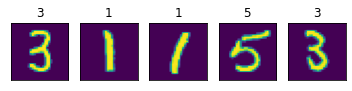

In [14]:
plot_example(X_train, y_train)

In [15]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
# X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Rescale the images from [0,255] to the [0.0,1.0] range.
X_train, X_test = X_train[..., np.newaxis]/255.0, X_test[..., np.newaxis]/255.0
X_validation = X_validation[..., np.newaxis]/255.0

# print("Number of original training examples:", len(x_train))
# print("Number of original test examples:", len(x_test))

print( X_train.shape, X_validation.shape, X_test.shape)

(54000, 28, 28, 1) (6000, 28, 28, 1) (10000, 28, 28, 1)


In [16]:
# np.unique(y_train.head(100))
paper_name

'mnist'

In [17]:
train_data = X_train
validation_data = X_validation
test_data = X_test
train_targets = y_train
validation_targets = y_validation
test_targets = y_test

In [18]:
# extracts the layer from a model using the name
def get_layer_by_name(layers, name, return_first=True):
    matching_named_layers = [l for l in layers if l.name == name]
    if not matching_named_layers:
        return None
    return matching_named_layers[0] if return_first else matching_named_layers


In [19]:
# plotting utilities for the history of the fit
def plot_history(history):
    acc_keys = [k for k in history.history.keys() if 'accuracy' in k]
    loss_keys = [k for k in history.history.keys() if not k in acc_keys]
    for k, v in history.history.items():
        if k in acc_keys:
            plt.figure(1)
            plt.plot(v)
        else:
            plt.figure(2)
            plt.plot(v)
    plt.figure(1)
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(acc_keys, loc='lower right')
    plt.figure(2)
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loss_keys, loc='upper right')
    plt.show()

def plot_history_df(history):
    acc_keys = [k for k in history.columns.values if 'accuracy' in k]
    loss_keys = [k for k in history.columns.values if not k in acc_keys and not k in ['epoch']]
    for k, v in history.items():
        if k in acc_keys:
            plt.figure(1)
            plt.plot(v)
        if k in loss_keys:
            plt.figure(2)
            plt.plot(v)
    plt.figure(1)
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(acc_keys, loc='lower right')
    plt.figure(2)
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loss_keys, loc='upper right')
    plt.show()   


A function that will take a model construction function (with _model_name_ and _input_shape_ arguments), train and fit it using the supplied data and callbacks. The _kwargs_ are supplied to the model fit function.

In [20]:
from tensorflow.keras.callbacks import CSVLogger
import datetime

def compile_and_fit_model_basic(  model_func,
                                  model_name,
                                  input_shape,
                                  X_train,
                                  Y_train,
                                  save_max_epoch=True,
                                  save_final=False,
                                  patience_count = None,
                                  early_stopping_obs = 'val_categorical_accuracy',
                                  log_history = True,
                                  verbose_level = 0,
                                  **kwargs):
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)
      
    if 'validation_data' not in kwargs.keys() and 'val_' in early_stopping_obs:
        early_stopping_obs = early_stopping_obs.replace('val_','')

    callbacks_used = []
    if save_max_epoch:
        callbacks_used.append(ModelCheckpoint(f'/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/{m.name}' + '_model_{epoch:03d}_{accuracy:0.3f}',
                                              save_weights_only=False,
                                              monitor = early_stopping_obs,
                                              mode='max',
                                              save_best_only=True))
    if patience_count is not None:
        callbacks_used.append(tf.keras.callbacks.EarlyStopping(monitor=early_stopping_obs, patience=patience_count))

    if log_history:
        callbacks_used.append(tf.keras.callbacks.CSVLogger(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/history_log_{model_name}_{datetime.date.today().strftime('%Y%m%d')}.csv", append=True))

    m.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

    # m.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    #           optimizer=tf.keras.optimizers.Adam(), 
    #           metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    
# model.compile(optimizer='adam', # learning rate will be set by LearningRateScheduler
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

    history = m.fit(X_train, Y_train, callbacks=callbacks_used, verbose=verbose_level, **kwargs)
    if save_final:
        make_dir_if_not_exist(model_name)
        m.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{m.name}_saved_model_after_fit")  # Save the model
    return (m, history)

Some functions to get scores on the results

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import re

def get_confusion_matrix_classification(model, X, Y_true):
    y_pred = model.predict(X)
    y_true = np.apply_along_axis(np.argmax, 1, Y_true)
    y_pred = np.apply_along_axis(np.argmax, 1, y_pred)
    return (confusion_matrix(y_true, y_pred), y_pred, y_true)

def construct_confusion_matrix(X, Y_true, Y_pred):
    y_true = Y_true
    y_pred = np.apply_along_axis(np.argmax, 1, Y_pred)
    return (confusion_matrix(y_true, y_pred), y_pred, y_true)

def pr_rc_f1_acc_from_supplied(y_pred, y_true):  
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")   
    acc = accuracy_score(y_true, y_pred)
    return pr, rc, f1, acc


In [22]:
import re
import os

def dir_has_file_with_regex(dir_name, regex_string):
  filenames = [ f"{dir_name}/{dir_entry.name}" for dir_entry in os.scandir(dir_name) if os.path.isfile(f"{dir_name}/{dir_entry.name}") ]   
  filenames = [ fn for fn in filenames if re.match(regex_string, fn, re.IGNORECASE) ]
  return filenames


In [23]:
# dir_has_file_with_regex("/content/drive/MyDrive/data_papers/gpSVHN/model_features", "^.*DNN_A_.*D3R_Test_X.*")

In [24]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-ae7b16b5-ff8c-b3c4-8d2b-530a5c0530aa)


In [25]:
!pip install ipython-autotime

In [26]:
%load_ext autotime

time: 126 µs (started: 2022-01-25 16:41:26 +00:00)


In [27]:
import timeit

time: 1.01 ms (started: 2022-01-25 16:41:26 +00:00)


# Imports

In [28]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
AUTOTUNE = tf.data.AUTOTUNE
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.7.0
time: 11.8 ms (started: 2022-01-25 16:41:26 +00:00)


In [29]:
#@title visualization utilities [RUN ME]
"""
This cell contains helper functions used for visualization
and downloads only. You can skip reading it. There is very
little useful Keras/Tensorflow code here.
"""

# Matplotlib config
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets. This code is not very nice, it gets much better in eager mode (TODO)
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  
  # get one batch from each: 10000 validation digits, N training digits
  batch_train_ds = training_dataset.unbatch().batch(N)
  
  # eager execution: loop through datasets normally
  for validation_digits, validation_labels in validation_dataset:
    validation_digits = validation_digits.numpy()
    validation_labels = validation_labels.numpy()
    break
  for training_digits, training_labels in batch_train_ds:
    training_digits = training_digits.numpy()
    training_labels = training_labels.numpy()
    break
  
  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)
  
  return (training_digits, training_labels,
          validation_digits, validation_labels)

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (28*n, 28), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*28,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [28, 28*n]), n, axis=1), axis=0), [n, 28*28])
  return font_digits, font_labels

# utility to display a row of digits with their predictions
def display_digits(digits, predictions, labels, title, n):
  plt.figure(figsize=(13,3))
  digits = np.reshape(digits, [n, 28, 28])
  digits = np.swapaxes(digits, 0, 1)
  digits = np.reshape(digits, [28, 28*n])
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i] != labels[i]: t.set_color('red') # bad predictions in red
  plt.imshow(digits)
  plt.grid(None)
  plt.title(title)
  
# utility to display multiple rows of digits, sorted by unrecognized/recognized status
def display_top_unrecognized(digits, predictions, labels, n, lines):
  idx = np.argsort(predictions==labels) # sort order: unrecognized first
  for i in range(lines):
    display_digits(digits[idx][i*n:(i+1)*n], predictions[idx][i*n:(i+1)*n], labels[idx][i*n:(i+1)*n],
                   "{} sample validation digits out of {} with bad predictions in red and sorted first".format(n*lines, len(digits)) if i==0 else "", n)
    
# utility to display training and validation curves
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.grid(linewidth=1, color='white')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

time: 111 ms (started: 2022-01-25 16:41:26 +00:00)


# TPU or GPU detection

In [30]:
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines
print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of accelerators:  1
time: 631 ms (started: 2022-01-25 16:41:26 +00:00)


# tf.data.Dataset: parse files and prepare training and validation datasets
Please read the [best practices for building](https://www.tensorflow.org/guide/performance/datasets) input pipelines with tf.data.Dataset

In [31]:
training_images_file   = 'gs://mnist-public/train-images-idx3-ubyte'
training_labels_file   = 'gs://mnist-public/train-labels-idx1-ubyte'
validation_images_file = 'gs://mnist-public/t10k-images-idx3-ubyte'
validation_labels_file = 'gs://mnist-public/t10k-labels-idx1-ubyte'

time: 2.16 ms (started: 2022-01-25 16:41:26 +00:00)


In [32]:
def read_label(tf_bytestring):
    label = tf.io.decode_raw(tf_bytestring, tf.uint8)
    label = tf.reshape(label, [])
    label = tf.one_hot(label, 10)
    return label
  
def read_image(tf_bytestring):
    image = tf.io.decode_raw(tf_bytestring, tf.uint8)
    image = tf.cast(image, tf.float32)/256.0
    image = tf.reshape(image, [28*28])
    return image
  
def load_dataset(image_file, label_file):
    imagedataset = tf.data.FixedLengthRecordDataset(image_file, 28*28, header_bytes=16)
    imagedataset = imagedataset.map(read_image, num_parallel_calls=16)
    labelsdataset = tf.data.FixedLengthRecordDataset(label_file, 1, header_bytes=8)
    labelsdataset = labelsdataset.map(read_label, num_parallel_calls=16)
    dataset = tf.data.Dataset.zip((imagedataset, labelsdataset))
    return dataset 
  
def get_training_validation_dataset(image_file, label_file, batch_size):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache()  # this small dataset can be entirely cached in RAM
    # dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
    dataset = dataset.repeat()      # the batching will repeat infinitely if you keep doing this... bad for the features...
    validation_dataset = dataset.take(10000) 
    train_dataset = dataset.skip(10000)
    validation_dataset = validation_dataset.batch(batch_size)
    validation_dataset = validation_dataset.prefetch(AUTOTUNE)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
    train_dataset = train_dataset.batch(batch_size)
    train_dataset = train_dataset.prefetch(AUTOTUNE)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
    return train_dataset, validation_dataset
  
def get_test_dataset(image_file, label_file):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache() # this small dataset can be entirely cached in RAM
    dataset = dataset.batch(10000)
    return dataset

def get_training_validation_dataset_unrepeat(image_file, label_file, batch_size):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache()  # this small dataset can be entirely cached in RAM
    # dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
    # dataset = dataset.repeat()      # the batching will repeat infinitely if you keep doing this... bad for the features...
    validation_dataset = dataset.take(10000) 
    train_dataset = dataset.skip(10000)
    validation_dataset = validation_dataset.batch(batch_size)
    validation_dataset = validation_dataset.prefetch(AUTOTUNE)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
    train_dataset = train_dataset.batch(batch_size)
    train_dataset = train_dataset.prefetch(AUTOTUNE)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
    return train_dataset, validation_dataset

# def get_training_validation_dataset_unrepeat_rotate(image_file, label_file, batch_size):
#     dataset = load_dataset(image_file, label_file)
#     dataset = dataset.cache()  # this small dataset can be entirely cached in RAM
#     # dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
#     # dataset = dataset.repeat()      # the batching will repeat infinitely if you keep doing this... bad for the features...
#     validation_dataset = dataset.take(10000) 
#     train_dataset = dataset.skip(10000)
#     validation_dataset = validation_dataset.batch(batch_size)
#     # tf.contrib.image.rotate(images, degrees * math.pi / 180, interpolation='BILINEAR')

#     validation_dataset = validation_dataset.prefetch(AUTOTUNE)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
#     train_dataset = train_dataset.batch(batch_size)
#     train_dataset = train_dataset.prefetch(AUTOTUNE)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
#     return train_dataset, validation_dataset


# def get_full_training_mnist():
#     dataset = load_dataset(training_images_file, training_labels_file)
#     dataset = dataset.cache()  # this small dataset can be entirely cached in RAM
#     dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
#     dataset = dataset.repeat()
#     validation_dataset = dataset.take(10000) 
#     train_dataset = dataset.skip(10000)


BATCH_SIZE = 700
# instantiate the datasets
training_dataset, validation_dataset = get_training_validation_dataset(training_images_file, training_labels_file, BATCH_SIZE)
test_dataset = get_test_dataset(validation_images_file, validation_labels_file)



time: 428 ms (started: 2022-01-25 16:41:26 +00:00)


In [33]:
training_dataset_full, test_dataset_full = get_training_validation_dataset(training_images_file, training_labels_file, BATCH_SIZE)

time: 102 ms (started: 2022-01-25 16:41:27 +00:00)


# Let's have a look at the data

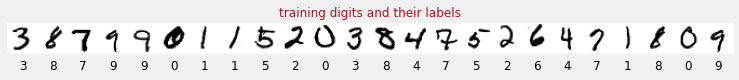

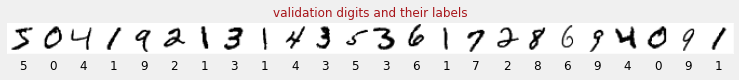

time: 2.15 s (started: 2022-01-25 16:41:27 +00:00)


In [34]:
N = 24
(training_digits, training_labels,
 validation_digits, validation_labels) = dataset_to_numpy_util(training_dataset, validation_dataset, N)
display_digits(training_digits, training_labels, training_labels, "training digits and their labels", N)
display_digits(validation_digits[:N], validation_labels[:N], validation_labels[:N], "validation digits and their labels", N)
font_digits, font_labels = create_digits_from_local_fonts(N)

# Set up the models + features file lists for CNN/DNN splits for reuse MNIST

In [35]:
acceptable_string_grabs = [ "CNN_A_", "DNN_A_", "RestNet50_A_", "WideResNet28-10_ID"]
not_check_model_string = ["arallel","Collab_"]

model_dirs = [  f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}" 
                for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/") 
                if os.path.isdir(dir_entry) and any(xs in dir_entry.name for xs in acceptable_string_grabs) ]
dnn_model_dirs = [ s for s in model_dirs if "DNN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
cnn_model_dirs = [ s for s in model_dirs if "CNN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
resnets_model_dirs = [ s for s in model_dirs if "RestNet50" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
wideresnets_model_dirs = [ s for s in model_dirs if "WideResNet" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 

model_features_files = [  f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{file_entry.name}" 
                for file_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/") 
                if os.path.isfile(file_entry) and any(xs in file_entry.name for xs in acceptable_string_grabs) ]

dnn_features_files = [ s for s in model_features_files if "DNN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
cnn_features_files = [ s for s in model_features_files if "CNN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
resnets_features_files = [ s for s in model_features_files if "RestNet50" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
wideresnets_features_files = [ s for s in model_features_files if "WideResNet" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 

dnn_identifier = acceptable_string_grabs[1]
# dnn_layer_name = "DRP1"

cnn_identifier = acceptable_string_grabs[0]
# cnn_layer_name = "D3R"

wideresnet_identifier = acceptable_string_grabs[3]
# wideresnet_layer_name = "CLASSIFIER_FL"


def avgfilter_ensemble_predictions(y_pred_ms, xtest):
  y_preds_ens_prb = np.apply_along_axis(np.mean, 0, y_pred_ms)
  y_preds_ens_idx = np.apply_along_axis(np.argmax, 1, y_preds_ens_prb) 
  # y_preds_ens_idx = y_preds_ens_idx + 1
  return y_preds_ens_idx  




time: 333 ms (started: 2022-01-25 16:41:29 +00:00)


# Function for writing the features and getting (un)batched data sets to be used

A function that given a model or model directory create a new model up to the _layer_name_, then write the features matching the supplied _X_ and _Y_ as numpy arrays to google drive.

In [36]:
# note the removal of the Y feature writing...
def write_features_from_models(
        model_entry,
        layer_name,
        data_set_input,
        normalize_X_func=None,
        dataset_id = "NA",
        **kwargs):
  
    model_here = None
    if isinstance(model_entry, tf.keras.models.Model):
        model_here = model_entry
        model_file_name = model_here.name
    else:
        model_here = tf.keras.models.load_model(model_entry,**kwargs) 

    features_model = Model(model_here.input,
                            get_layer_by_name(model_here.layers, layer_name).output)
    if normalize_X_func is None:
        X_new = np.array(features_model.predict(data_set_input), dtype='float64')
    else:
        X_new = np.array(normalize_X_func(features_model.predict(data_set_input)), dtype='float64')

    np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{model_here.name}_features_{layer_name}_{dataset_id}_X", X_new, 
               allow_pickle=True, 
               fix_imports=True)
    

time: 7.07 ms (started: 2022-01-25 16:41:29 +00:00)


In [37]:
def unbatch_dataset_in_two(input_dataset):

  images = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  labels = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)

  for x, y in input_dataset.unbatch():
    images = images.write(images.size(), x)
    labels = labels.write(labels.size(), y)

  images = tf.stack(images.stack(), axis=0)
  labels = tf.stack(labels.stack(), axis=0)

  return (images.numpy(), labels.numpy())


time: 5.82 ms (started: 2022-01-25 16:41:29 +00:00)


In [38]:
training_dataset_unrepeat, validation_dataset_unrepeat = get_training_validation_dataset_unrepeat(training_images_file, training_labels_file, BATCH_SIZE)
test_X_images, test_Y_labels = unbatch_dataset_in_two(test_dataset)
validation_X_images, validation_Y_labels = unbatch_dataset_in_two(validation_dataset_unrepeat)
train_X_images, train_Y_labels = unbatch_dataset_in_two(training_dataset_unrepeat)  

time: 52.2 s (started: 2022-01-25 16:41:29 +00:00)


In [39]:
print(train_X_images.shape, validation_X_images.shape, test_X_images.shape)
test_Y_labels = test_Y_labels.astype('int32')
validation_Y_labels = validation_Y_labels.astype('int32')
train_Y_labels = train_Y_labels.astype('int32')

test_Y_labels_as_numbers = np.apply_along_axis(np.argmax, 1, test_Y_labels)

(50000, 784) (10000, 784) (10000, 784)
time: 49.1 ms (started: 2022-01-25 16:42:22 +00:00)


# Create some summary data




In [ ]:
# getting the scores for the individual DNNs on the test data set
scores_dnn_simple = []
check_model_string = "DNN_MNIST_"
not_check_model_string = ["arallel","Collab_"]

dir_entries = os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/")
dir_entries = [ de for de in list(dir_entries) if os.path.isdir(de) and check_model_string in de.name and all([ (not ncs in de.name) for ncs in not_check_model_string]) ]

for dir_entry in dir_entries:
  print(dir_entry.name)
  model_here = tf.keras.models.load_model(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}")  
  y_predict_here = np.array(model_here.predict(test_X_images), dtype='float64')
  y_predict_here = np.apply_along_axis(np.argmax, 1, y_predict_here)
  scores_dnn_simple.append(pr_rc_f1_acc_from_supplied(y_predict_here, test_Y_labels_as_numbers))

np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/individual_dnn_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", np.array(scores_dnn_simple), 
               allow_pickle=True, 
               fix_imports=True)

individual_dnn_summary = pd.DataFrame(scores_dnn_simple, columns=["Pr","Rc","F1","Acc"])
individual_dnn_summary['Type'] = "DNN"
individual_dnn_summary['Data'] = "Test"
individual_dnn_summary.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/individual_dnn_summary_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")


In [40]:
# getting the scores for the individual CNNs on the test data set
import os

scores_cnn_simple = []
check_model_string = "CNN_MNIST_"
not_check_model_string = ["arallel","Collab_"]

dir_entries = os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/")
dir_entries = [ de for de in list(dir_entries) if os.path.isdir(de) and check_model_string in de.name and all([ (not ncs in de.name) for ncs in not_check_model_string]) ]

for dir_entry in dir_entries:
  print(dir_entry.name)
  model_here = tf.keras.models.load_model(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}")  
  y_predict_here = np.array(model_here.predict(test_X_images), dtype='float64')
  y_predict_here = np.apply_along_axis(np.argmax, 1, y_predict_here)
  scores_cnn_simple.append(pr_rc_f1_acc_from_supplied(y_predict_here, test_Y_labels_as_numbers))

np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/individual_cnn_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", np.array(scores_cnn_simple), 
               allow_pickle=True, 
               fix_imports=True)

individual_cnn_summary = pd.DataFrame(scores_cnn_simple, columns=["Pr","Rc","F1","Acc"])
individual_cnn_summary['Type'] = "CNN"
individual_cnn_summary['Data'] = "Test"
individual_cnn_summary.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/individual_cnn_summary_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")

CNN_MNIST_1_20220121165139_saved_model_after_fit
CNN_MNIST_2_20220121165939_saved_model_after_fit
CNN_MNIST_3_20220121170054_saved_model_after_fit
CNN_MNIST_4_20220121170206_saved_model_after_fit
CNN_MNIST_5_20220121170320_saved_model_after_fit
CNN_MNIST_6_20220121170434_saved_model_after_fit
CNN_MNIST_7_20220121170547_saved_model_after_fit
CNN_MNIST_8_20220121170659_saved_model_after_fit
CNN_MNIST_9_20220121170811_saved_model_after_fit
CNN_MNIST_10_20220121170924_saved_model_after_fit
CNN_MNIST_11_20220121171037_saved_model_after_fit
CNN_MNIST_12_20220121171150_saved_model_after_fit
CNN_MNIST_13_20220121171301_saved_model_after_fit
CNN_MNIST_14_20220121171413_saved_model_after_fit
CNN_MNIST_15_20220121171525_saved_model_after_fit
CNN_MNIST_16_20220121171640_saved_model_after_fit
CNN_MNIST_17_20220121171754_saved_model_after_fit
CNN_MNIST_18_20220121171907_saved_model_after_fit
CNN_MNIST_19_20220121172020_saved_model_after_fit
CNN_MNIST_20_20220121172134_saved_model_after_fit
CNN_MNIST

# Set up data and functions




In [38]:
time_map = { "DNN" : 27.0, 
            "CNN" : 32.0,  
            "Ensemble":  1.0, "Softmax" : 50.0, "Softmax_Unit": 20.0, "LastDense": 80.0, "LastDense_Unit": 20.0,
            "Integrated20CNN" : 420.0, "Integrated20DNN" : 282.0, "Integrate10CNN10RNN": 347.0,
              }

time: 2.21 ms (started: 2022-01-25 16:28:18 +00:00)


In [41]:
import pandas as pd

def get_validation_acc_from_history_file(f1):
  pd1 = pd.read_csv(f1)
  return pd1[pd1.epoch==max(pd1.epoch)].val_sparse_categorical_accuracy.iloc[0]


time: 3.66 ms (started: 2022-01-25 17:19:09 +00:00)


In [ ]:
# get validation and test accuracies
# val_accs = pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/val_test_accs_20211118165251.csv")
# best_submodels = val_accs.loc[val_accs.groupby("Type")['ValAcc'].idxmax()].copy()

In [42]:
# get collab data from last dense
all_lastdense_collab_data = pd.concat([ pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/{f}") for f in os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/") if "collab_lastdense_test_results" in f ])
all_lastdense_collab_data = all_lastdense_collab_data.drop_duplicates()
all_lastdense_collab_data["BestComponent"] = np.nan
# for typename in best_submodels["Type"]:
#   all_lastdense_collab_data.loc[all_lastdense_collab_data.Type==typename,"BestComponent"] = float(best_submodels.loc[best_submodels.Type==typename, "TestAcc"])
all_lastdense_collab_data["Layer"] = "LastDense"
all_lastdense_collab_data["Xtra"] = "Random"

# get collab data from softmax
all_sftmx_collab_data = pd.concat([ pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/{f}") for f in os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/") if "collab_test_results" in f ])
all_sftmx_collab_data = all_sftmx_collab_data.drop_duplicates()
all_sftmx_collab_data["BestComponent"] = np.nan
# for typename in best_submodels["Type"]:
#   all_sftmx_collab_data.loc[all_sftmx_collab_data.Type==typename,"BestComponent"] = float(best_submodels.loc[best_submodels.Type==typename, "TestAcc"])
all_sftmx_collab_data["Layer"] = "Softmax"
all_sftmx_collab_data["Xtra"] = "Random"

# get ensemble data
all_ensemble_data =  pd.concat([ pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/{f}").reset_index(drop=True) for f in os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results") if "ensemble" in f and ".csv" in f and "contour" not in f])
all_ensemble_data = all_ensemble_data.drop_duplicates() 
all_ensemble_data = all_ensemble_data[["Type","Data", "NumOfModels",	"RepC"	,"Pr", "Rc",	"F1" , "Acc"]]
all_ensemble_data["BestComponent"] = np.nan
# for typename in best_submodels["Type"]:
#   all_ensemble_data.loc[all_ensemble_data.Type==typename,"BestComponent"] = float(best_submodels.loc[best_submodels.Type==typename, "TestAcc"])
all_ensemble_data["Layer"] = "Ensemble"
all_ensemble_data["Xtra"] = "Random"


time: 3.88 s (started: 2022-01-25 17:38:34 +00:00)


In [ ]:
# # get collab using CCA on softmax
# all_sftmx_collab_cca = pd.concat([ pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/{f}") for f in os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/") if "collab_ccaorder_sftmx_test_results" in f ])
# all_sftmx_collab_cca = all_sftmx_collab_cca.drop_duplicates()
# all_sftmx_collab_cca["BestComponent"] = np.nan
# for typename in best_submodels["Type"]:
#   all_sftmx_collab_cca.loc[all_sftmx_collab_cca.Type==typename,"BestComponent"] = float(best_submodels.loc[best_submodels.Type==typename, "TestAcc"])
# all_sftmx_collab_cca["Layer"] = "Softmax"



In [ ]:
# all_sftmx_collab_data = pd.concat([all_sftmx_collab_data,all_sftmx_collab_cca], ignore_index=True)
# all_sftmx_collab_data.loc[all_sftmx_collab_data.Xtra!="CCAmin","Xtra"] = "Random"

In [43]:
# print(len(all_sftmx_collab_data.index),len(all_lastdense_collab_data.index))
test_acc_data = pd.concat([all_lastdense_collab_data.reset_index(drop=True), all_sftmx_collab_data.reset_index(drop=True), all_ensemble_data.reset_index(drop=True)])


time: 30.4 ms (started: 2022-01-25 17:40:29 +00:00)


In [44]:
# test_acc_data[test_acc_data.Xtra=="Ensemble"]
all_ensemble_data.head(4)

,Type,Data,NumOfModels,RepC,Pr,Rc,F1,Acc,BestComponent,Layer,Xtra
0,DNN,Test,2,0,0.984408,0.9844,0.984402,0.9844,NaN,Ensemble,Random
1,DNN,Test,2,1,0.983208,0.9832,0.983196,0.9832,NaN,Ensemble,Random
2,DNN,Test,2,2,0.985310,0.9853,0.985297,0.9853,NaN,Ensemble,Random
3,DNN,Test,2,3,0.984513,0.9845,0.984502,0.9845,NaN,Ensemble,Random


time: 23.6 ms (started: 2022-01-25 17:40:33 +00:00)


In [46]:
sftmx_contour_data = pd.concat([ pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/{f}") for f in  os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/") if "cnn_dnn_collab_contour_data" in f ])
sftmx_contour_data = sftmx_contour_data.drop_duplicates()
sftmx_contour_data["NumOfModels"] = sftmx_contour_data.NumOfA + sftmx_contour_data.NumOfB
sftmx_contour_data["Type"] = "CNN_DNN"
sftmx_contour_data["CNN%"] = sftmx_contour_data.NumOfA/sftmx_contour_data["NumOfModels"]

time: 378 ms (started: 2022-01-25 17:41:36 +00:00)


In [ ]:
# sftmx_cwcontour_data = pd.concat([ pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/{f}") for f in  os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/") if "cnn_wideresnet_contour_data" in f ])
# sftmx_cwcontour_data = sftmx_cwcontour_data.drop_duplicates()
# sftmx_cwcontour_data["NumOfModels"] = sftmx_cwcontour_data.NumOfA + sftmx_cwcontour_data.NumOfB
# sftmx_cwcontour_data["Type"] = "CNN_WRN"
# sftmx_cwcontour_data["WR%"] = sftmx_cwcontour_data.NumOfB/sftmx_cwcontour_data["NumOfModels"]

In [47]:
# get all contour data
all_contour_data =  pd.concat([ pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/{f}").reset_index(drop=True) for f in os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results") if ".csv" in f and "contour" in f])
all_contour_data = all_contour_data.drop_duplicates() 
all_contour_data.loc[all_contour_data.Layer!="Ensemble","Layer"] = "Softmax"


time: 530 ms (started: 2022-01-25 17:41:59 +00:00)


In [ ]:
# test_acc_data.loc[max(test_acc_data.index)]["Pr"]

In [48]:
all_acc_data = pd.concat([test_acc_data.groupby(["Type","NumOfModels","Layer","Xtra"])["Acc"].mean(), test_acc_data.groupby(["Type","NumOfModels","Layer","Xtra"])["BestComponent"].mean()],axis=1)
all_acc_data = all_acc_data.reset_index()
all_acc_data = all_acc_data[all_acc_data.NumOfModels>1]


time: 24.5 ms (started: 2022-01-25 17:42:10 +00:00)


In [49]:
all_acc_data

,Type,NumOfModels,Layer,Xtra,Acc,BestComponent
0,CNN,2,Ensemble,Random,0.995200,NaN
1,CNN,2,LastDense,Random,0.993500,NaN
2,CNN,2,Softmax,Random,0.995000,NaN
3,CNN,3,Ensemble,Random,0.995400,NaN
4,CNN,3,LastDense,Random,0.993800,NaN
...,...,...,...,...,...,...
94,DNN,35,Softmax,Random,0.985600,NaN
95,DNN,40,Ensemble,Random,0.985587,NaN
96,DNN,40,Softmax,Random,0.984800,NaN
97,DNN,45,Softmax,Random,0.985400,NaN


time: 16.3 ms (started: 2022-01-25 17:42:17 +00:00)


In [ ]:
# # get the WideResNet gp data
# all_gp_data =  pd.concat([ pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/{f}").reset_index(drop=True) for f in os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results") if ".csv" in f and "Collab_gp_" in f and "WideResNet" in f])
# all_gp_data = all_gp_data.drop_duplicates() 
# all_gp_data = all_gp_data[all_gp_data.GPName == "matern12"]
# all_gp_data.reset_index(inplace=True)
# all_gp_data = all_gp_data[["Type","Data","NumOfModels","GPName","Pr","Rc","F1","Acc"]]
# # all_contour_data.loc[all_contour_data.Layer!="Ensemble","Layer"] = "Softmax"
# all_gp_data = all_gp_data.rename(columns={"GPName":"Xtra"})
# all_gp_data["Type"] = "WideResNet"  # leftover bug
# all_gp_data["Layer"] = "Softmax"

In [50]:
# all_acc_data = pd.concat([all_acc_data,all_gp_data], ignore_index=True)
all_acc_data_2 = pd.melt(all_acc_data, id_vars=['Type','NumOfModels','Layer','Xtra'], value_name="Acc", var_name="AccType")

time: 10.4 ms (started: 2022-01-25 17:42:37 +00:00)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resultiing Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Plots/Analysis of number of models by model type and ensemble/collab with layer information




/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 2 rows containing missing values.
  warn(msg.format(n1-n2), PlotnineWarning)


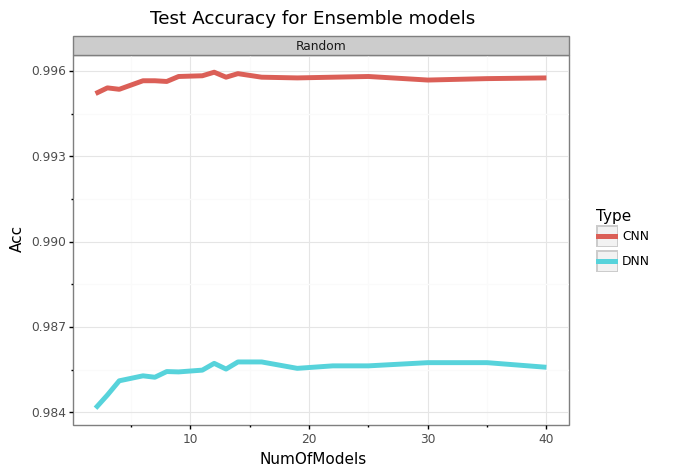

<ggplot: (8766985918245)>

time: 435 ms (started: 2022-01-25 18:08:04 +00:00)


In [51]:
ggplot(all_acc_data[all_acc_data.Layer=="Ensemble"]) +  \
geom_line(aes(x='NumOfModels',y='Acc',group='Type',color='Type', fill='Type'),size=2) +  \
geom_line(aes(x='NumOfModels',y='BestComponent',group='Type',color='Type', fill='Type'), linetype='dashed')  + theme_bw() + ggtitle('Test Accuracy for Ensemble models') + facet_grid('.~Xtra')

In [52]:
ensemble_regdata = all_acc_data[all_acc_data.Layer=="Ensemble"].copy()
ensemble_regdata_from_contour = all_contour_data[(all_contour_data.Layer == "Ensemble") & ((all_contour_data.NumOfA == 0)|(all_contour_data.NumOfB == 0))].copy()

ensemble_regdata.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/dwnld_svhn1_ensemble_regdata.csv", index=False)
ensemble_regdata_from_contour.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/dwnld_svhn2_ensemble_regdata.csv", index=False)

time: 37.8 ms (started: 2022-01-25 18:08:38 +00:00)


In [61]:
# all_acc_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/dwnld_svhn_a.csv", index=False)
# all_contour_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/dwnld_svhn_c.csv", index=False)

all_acc_data = all_acc_data.groupby(['Type','NumOfModels','Layer']).mean().reset_index()


time: 9.11 ms (started: 2022-01-25 18:11:59 +00:00)


In [64]:
all_acc_data[all_acc_data.Layer=="LastDense"]

,Type,NumOfModels,Layer,Acc,BestComponent
1,CNN,2,LastDense,0.993500,NaN
4,CNN,3,LastDense,0.993800,NaN
7,CNN,4,LastDense,0.994233,NaN
9,CNN,5,LastDense,0.993733,NaN
12,CNN,6,LastDense,0.994067,NaN
16,CNN,8,LastDense,0.994200,NaN
19,CNN,10,LastDense,0.993767,NaN
23,CNN,12,LastDense,0.994533,NaN
27,CNN,14,LastDense,0.994433,NaN
30,CNN,16,LastDense,0.993867,NaN


time: 31 ms (started: 2022-01-25 18:13:04 +00:00)


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


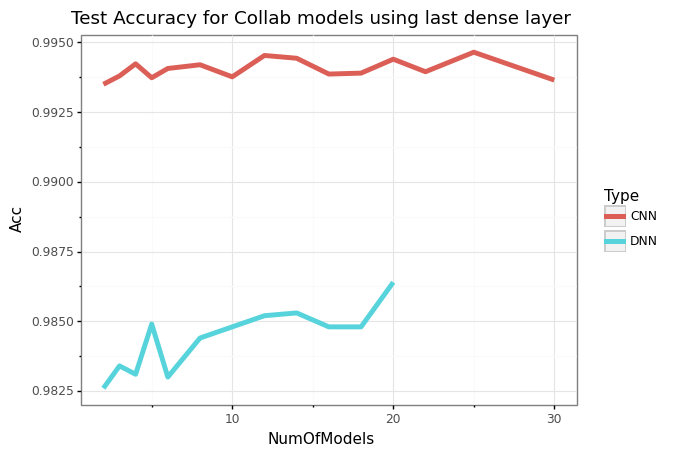

<ggplot: (8766984219197)>

time: 440 ms (started: 2022-01-25 18:13:54 +00:00)


In [65]:
ggplot(all_acc_data[all_acc_data.Layer=="LastDense"]) + \
geom_line(aes(x='NumOfModels',y='Acc',group='Type',color='Type', fill='Type'),size=2) + theme_bw() + \
ggtitle('Test Accuracy for Collab models using last dense layer') 

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


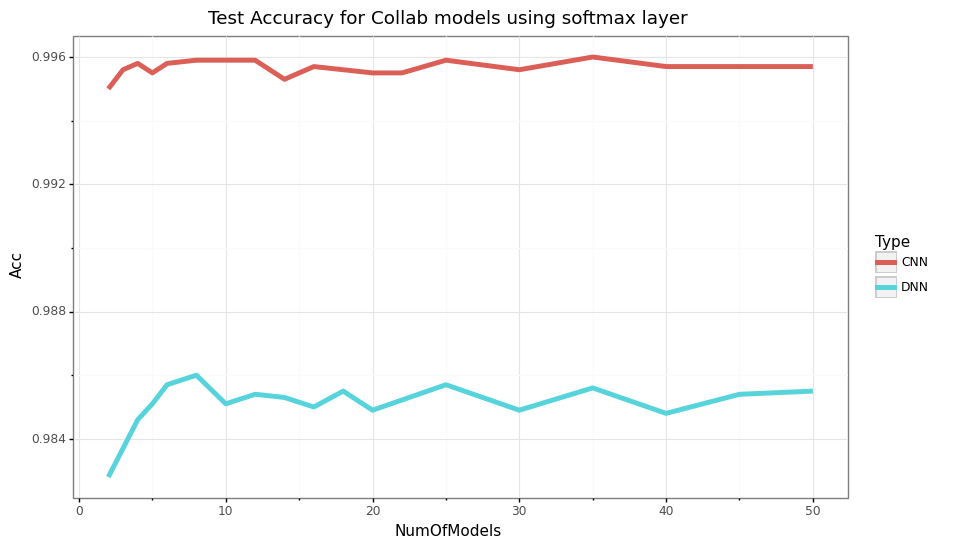

<ggplot: (8766984316845)>

time: 1.65 s (started: 2022-01-25 18:14:24 +00:00)


In [66]:
ggplot(all_acc_data[all_acc_data.Layer=="Softmax"]) + \
geom_line(aes(x='NumOfModels',y='Acc',group='Type',color='Type', fill='Type'),size=2) + \
theme_bw() + ggtitle('Test Accuracy for Collab models using softmax layer') + theme(figure_size = (10, 6))

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


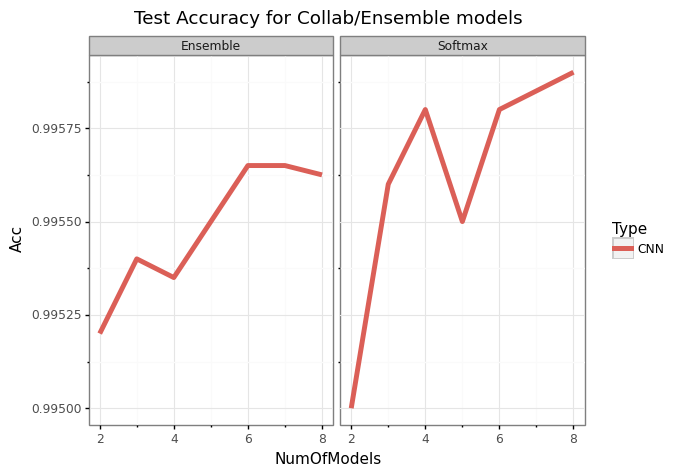

<ggplot: (8766986970605)>

time: 674 ms (started: 2022-01-25 18:45:44 +00:00)


In [82]:
ggplot(all_acc_data[(all_acc_data.NumOfModels<=8) & (all_acc_data.Layer!="LastDense") & (all_acc_data.Type!="DNN")]) + \
geom_line(aes(x='NumOfModels',y='Acc',group='Type',color='Type', fill='Type'),size=2) + \
facet_grid('.~Layer') + theme_bw() + ggtitle('Test Accuracy for Collab/Ensemble models')

In [ ]:
# ["B","B"] in [ "A", "B"]

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 2 rows containing missing values.
  warn(msg.format(n1-n2), PlotnineWarning)


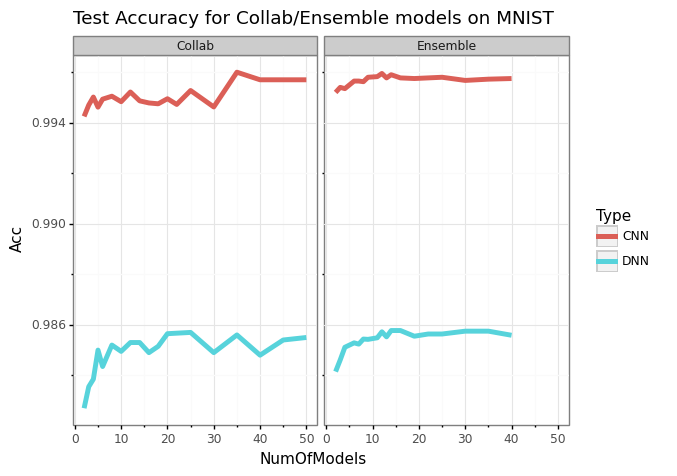

<ggplot: (8766905240333)>

time: 940 ms (started: 2022-01-25 18:17:50 +00:00)


In [74]:
collab_vs_ensemble = all_acc_data.copy()
collab_vs_ensemble.loc[collab_vs_ensemble.Layer != "Ensemble", "Layer"] = "Collab"
collab_vs_ensemble = collab_vs_ensemble.groupby(['Type','NumOfModels','Layer']).mean().reset_index()

ggplot(collab_vs_ensemble) + \
geom_line(aes(x='NumOfModels',y='Acc',group='Type',color='Type', fill='Type'),size=2) + \
geom_line(aes(x='NumOfModels',y='BestComponent',group='Type',color='Type', fill='Type'), linetype='dashed') + \
facet_grid('.~Layer') + theme_bw() + ggtitle('Test Accuracy for Collab/Ensemble models on MNIST')

In [72]:
collab_vs_ensemble[collab_vs_ensemble.NumOfModels == 20]

,Type,NumOfModels,Layer,Acc,BestComponent
24,CNN,20,Collab,0.99495,NaN
60,DNN,20,Collab,0.98565,NaN


time: 35.3 ms (started: 2022-01-25 18:17:11 +00:00)


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


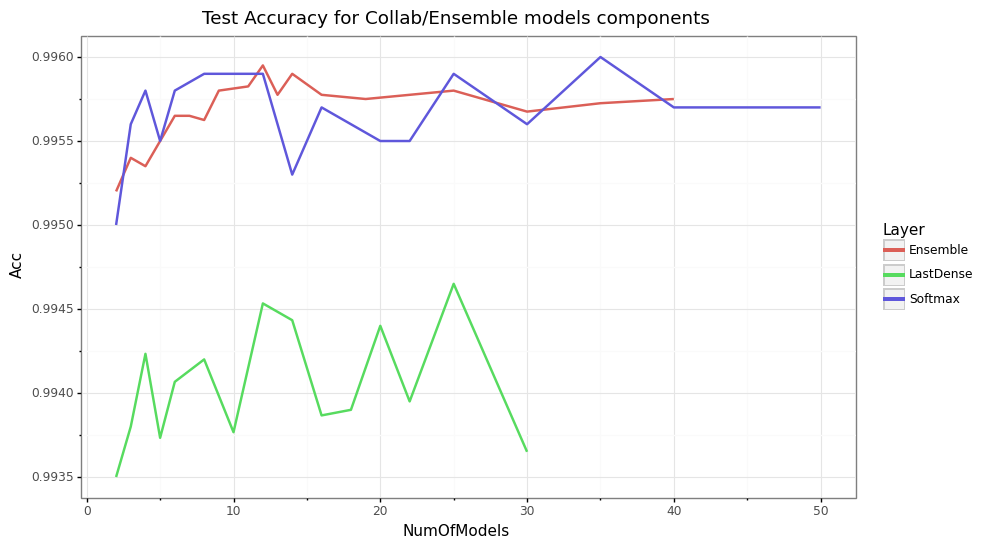

<ggplot: (8766937040145)>

time: 622 ms (started: 2022-01-25 18:39:35 +00:00)


In [76]:
cnn_data = all_acc_data[all_acc_data.Type=="CNN"].copy()

ggplot(cnn_data) + \
geom_line(aes(x='NumOfModels',y='Acc',group='Layer',color='Layer', fill='Layer'),size=1) + \
theme_bw() + ggtitle('Test Accuracy for Collab/Ensemble models components') + theme(figure_size = (10, 6))

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


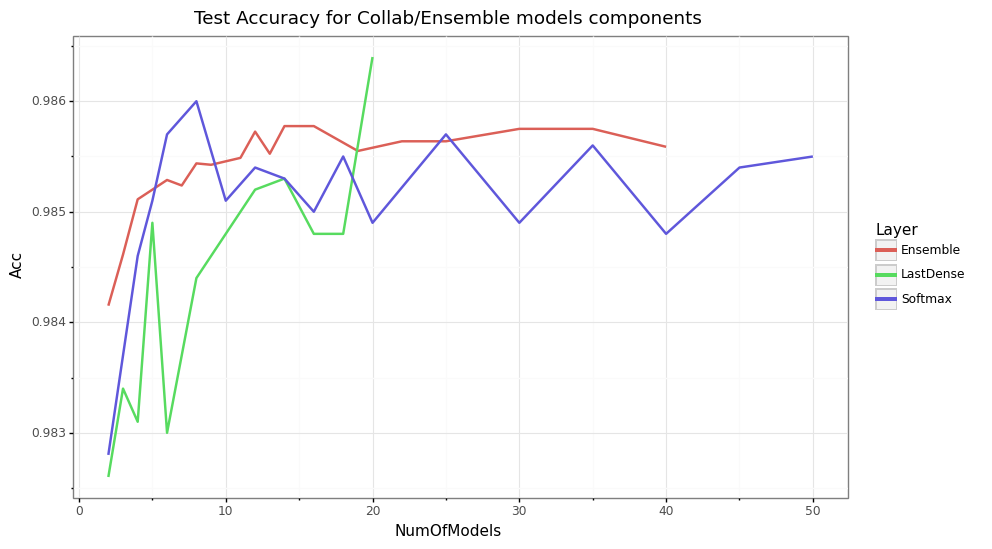

<ggplot: (8766986173745)>

time: 555 ms (started: 2022-01-25 18:40:10 +00:00)


In [78]:
dnn_data = all_acc_data[all_acc_data.Type=="DNN"].copy()
# dnn_data['Layer'] = dnn_data[['Layer', 'Xtra']].agg('_'.join, axis=1)

ggplot(dnn_data) + \
geom_line(aes(x='NumOfModels',y='Acc',group='Layer',color='Layer', fill='Layer'),size=1) + \
theme_bw() + ggtitle('Test Accuracy for Collab/Ensemble models components') + theme(figure_size = (10, 6))

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning:

geom_path: Removed 11 rows containing missing values.



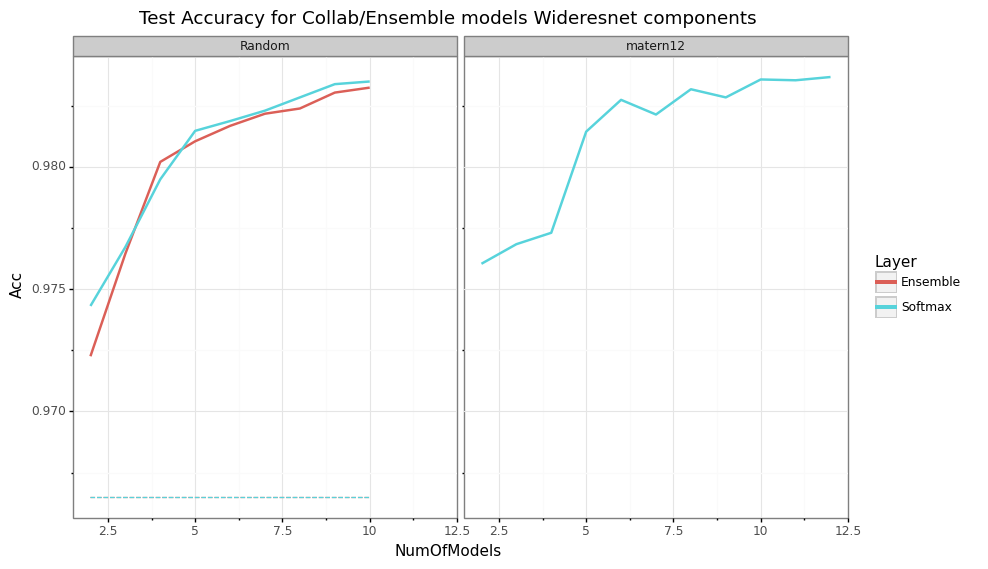

<ggplot: (8776432558769)>

In [ ]:
ggplot(all_acc_data[all_acc_data.Type=="WideResNet"]) + \
geom_line(aes(x='NumOfModels',y='Acc',group='Layer',color='Layer', fill='Layer'),size=1) + \
geom_line(aes(x='NumOfModels',y='BestComponent',group='Layer',color='Layer', fill='Layer'), linetype='dashed') + facet_grid('.~Xtra') + theme_bw() + ggtitle('Test Accuracy for Collab/Ensemble models Wideresnet components') + theme(figure_size = (10, 6))
